In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
%matplotlib inline

In [29]:
import matplotlib.pyplot as plt
from matplotlib import cm
import h5py
import numpy as np

In [ ]:
# downloaded from https://www.clumpy.org/pages/seds.html

In [7]:
data_loc = '/media/mike/internal/agnfinder/clumpy_models_201410_tvavg.hdf5'

In [167]:
with h5py.File(data_loc, 'r') as f:
    print(f.keys())
    wavelengths = f['wave'][...] * 1e4  # microns to angstroms
    opening_angle = f['sig'][...]
    inclination = f['i'][...]
    n0 = f['N0'][...]
    q = f['q'][...]
    y = f['Y'][...]
    tv = f['tv'][...]

<KeysViewHDF5 ['N0', 'Y', 'f2', 'flux_tor', 'flux_toragn', 'i', 'lam10', 'lam18', 'ptype1', 'q', 's10', 's18', 'sig', 'tv', 'wave']>


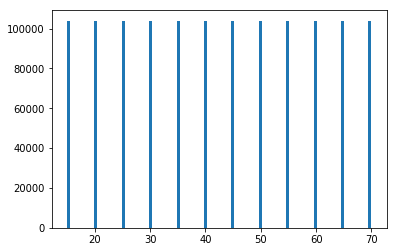

In [168]:
_ = plt.hist(opening_angle, bins=100)

In [169]:
desired_opening_angle = opening_angle == 30

In [170]:
with h5py.File(data_loc, 'r') as f:
    seds = f['flux_tor'][desired_opening_angle, :]
    

In [171]:
seds.shape

(103950, 119)

In [172]:
def get_log_space_median(x):
    return 10 ** np.median(np.log10(x), axis=0)

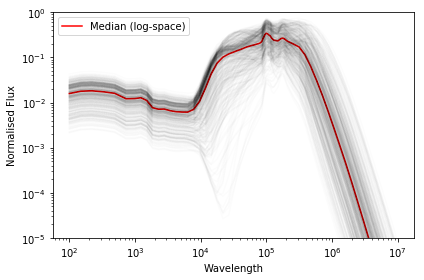

In [173]:
median_sed = get_log_space_median(seds)
plt.loglog(wavelengths, median_sed, 'r', label='Median (log-space)')
random_indices = np.random.choice(len(seds), 500)
random_seds = seds[random_indices]
for s in random_seds:
    plt.loglog(wavelengths, s, color='k', alpha=0.01)
plt.xlabel('Wavelength')
plt.ylabel('Normalised Flux')
plt.ylim([10**-5, 1])
plt.legend()
plt.tight_layout()

In [174]:
inclination_at_desired_opening = inclination[desired_opening_angle]

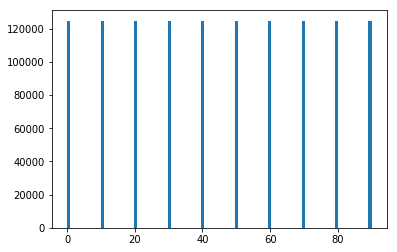

In [175]:
_ = plt.hist(inclination, bins=100)

In [176]:
assert inclination_at_desired_opening.min() == 0
normalised_inclination = inclination_at_desired_opening / inclination_at_desired_opening.max()
assert normalised_inclination.min() == 0
assert normalised_inclination.max() == 1.

In [177]:
selected_sed_index = np.argmax((n0 == 5) & (opening_angle == 30) & (q == 2) & (y == 30) & (tv == 30))
selected_sed = seds[selected_sed_index]

Text(0, 0.5, 'Flux')

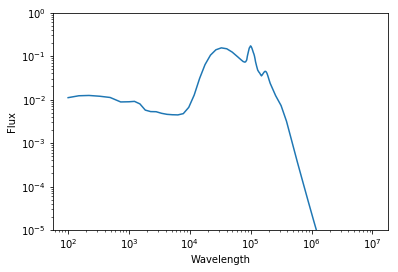

In [178]:
plt.loglog(wavelengths, selected_sed)
plt.ylim([10**-5, 1])
plt.xlabel('Wavelength')
plt.ylabel('Flux')

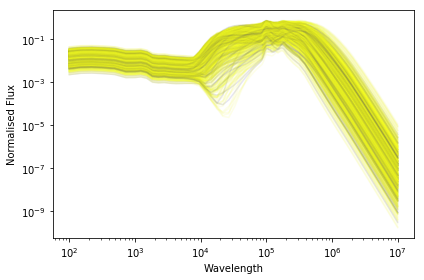

In [179]:
random_indices = np.random.choice(len(seds), 1000)
for n, s in enumerate(seds[random_indices]):
    plt.loglog(wavelengths, s, color=cm.plasma(normalised_inclination[n] * 255.), alpha=0.1)
plt.xlabel('Wavelength')
plt.ylabel('Normalised Flux')
plt.tight_layout()

That didn't work out so well...let's try again...

In [180]:
unique_inclinations = np.unique(inclination_at_desired_opening)
unique_inclinations

array([ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90], dtype=int32)

Text(0, 0.5, 'Flux')

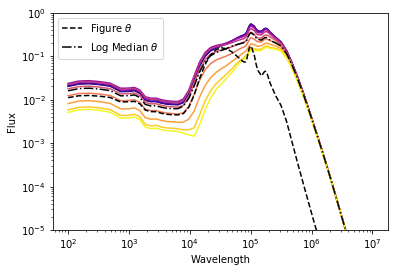

In [181]:
for inc in unique_inclinations:
    plt.loglog(wavelengths, get_log_space_median(seds[inclination_at_desired_opening == inc, :]), color=cm.plasma(inc / unique_inclinations.max()))
plt.loglog(wavelengths, selected_sed, 'k--', label=r'Figure $\theta$')
plt.loglog(wavelengths, get_log_space_median(seds), 'k-.', label=r'Log Median $\theta$')
plt.legend()
plt.ylim([10**-5, 1])
plt.xlabel('Wavelength')
plt.ylabel('Flux')

Lighter colors are higher inclinations, from 0 to 90*. For all but the reddest wavelengths, inclination is largely a shift in normalisation (though perhaps not for our specific template?).

Let's use the figure-suggested parameters for now, but be aware that they may be unusual - if the model struggles to get enough 10**2 -> 10**3 flux, consider using the median template instead.

In [182]:
import pandas as pd

In [183]:
df = pd.DataFrame(data={'wavelength': wavelengths, 'flux': selected_sed})

In [184]:
df.head()

,wavelength,flux
0,100.0,0.01105
1,150.0,0.01221
2,220.0,0.01241
3,330.0,0.01191
4,490.0,0.01115


In [185]:
df.to_csv('/home/mike/repos/agnfinder/data/selected_torus_template.csv', index=False)